In [119]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from datetime import datetime, timedelta
import pandas as pd
import math
import numpy as np
import random
from tqdm import trange

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

from math import sqrt
from scipy import stats

import matplotlib
# matplotlib.use('TkAgg')  # Switch to the TkAgg backend
import matplotlib.pyplot as plt
import datetime as dt

import torch
import torch.nn as nn
import time

import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [120]:
global save_path
name_sales = 'sales_train_evaluation.csv'
name_calendar = 'calendar.csv'
name_prices = 'sell_prices.csv'
save_name = 'M5'
window_size = 192
stride_size = 1
num_covariates = 6
train_start = '2011-01-29 00:00:00'
train_end = '2016-04-24 00:00:00'
test_start = '2016-04-25 00:00:00' #need additional 7 days as given info
test_end = '2016-05-22 00:00:00'
pred_days = 28
given_days = 7

In [121]:
save_path = os.path.join('data', save_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)
sales_csv_path = os.path.join(save_path, name_sales)
calendar_csv_path = os.path.join(save_path, name_calendar)
prices_csv_path = os.path.join(save_path, name_prices)

sales = pd.read_csv('data/data_sources/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('data/data_sources/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('data/data_sources/sell_prices.csv')
prices.name = 'prices'

#Create date index
date_index = calendar['date']
dates = date_index[0:1941]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales['item_store_id'] = sales.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
data_frame = sales.loc[:,'d_1':'d_1941'].T
data_frame.columns = sales['item_store_id'].values

#Set Dates as index 
data_frame = pd.DataFrame(data_frame).set_index([dates_list])
data_frame.index = pd.to_datetime(data_frame.index)
data_frame.head()

data_frame.shape

(1941, 30490)

In [122]:
def gen_m5_covariates(calendar_df, sales_df):
    # Assuming calendar_df is the calendar DataFrame and sales_df is the sales data DataFrame
    num_covariates = 6  # Example: day of week, month, SNAP_CA, SNAP_TX, SNAP_WI, event
    times = pd.to_datetime(calendar_df['date'])
    covariates = np.zeros((len(times), num_covariates))
    # Day of week and month as numerical values
    covariates[:, 0] = times.dt.dayofweek
    covariates[:, 1] = times.dt.month
    # SNAP days for CA, TX, and WI
    covariates[:, 2] = calendar_df['snap_CA']
    covariates[:, 3] = calendar_df['snap_TX']
    covariates[:, 4] = calendar_df['snap_WI']
    # Event (simple binary indicator for this example)
    covariates[:, 5] = calendar_df[['event_name_1', 'event_name_2']].notnull().any(axis=1).astype(int)
    # Standardize covariates (optional depending on model requirements)
    for i in range(num_covariates):
        covariates[:, i] = (covariates[:, i] - covariates[:, i].mean()) / covariates[:, i].std()
    return covariates

In [123]:
covariates = gen_m5_covariates(calendar, sales)
train_data = data_frame[train_start:train_end].values
test_data = data_frame[test_start:test_end].values
data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series
total_time = data_frame.shape[0] #1941 (days)
num_series = data_frame.shape[1] #30490 (item_id)
covariates = covariates[:1941,:]

In [124]:
new_data_frame = data_frame.values
new_data_frame = new_data_frame[:, :, np.newaxis]
new_covariates = covariates[:,np.newaxis,:]
# Broadcast c to match the shape of b along the last axis
new_covariates_broadcasted = np.broadcast_to(new_covariates, (1941, 30490, 6))

# Concatenate b and c along the last axis to create the new array
dataset = np.concatenate((new_data_frame, new_covariates_broadcasted), axis=-1)

# Slice the array to get the desired shape (1491, 30490, 7)
dataset = dataset[:1941, :, :]
dataset = np.swapaxes(dataset,0,1)

print(dataset.shape)  # Output: (1491, 30490, 7)

(30490, 1941, 7)


In [125]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]

'''
In fact, assuming that the number of samples is N, 
the length of the input sequence is m, and the backward prediction is k steps, 
then length of a block [input : 1 , 2 ... m  -> output : k , k+1....m+k ] 
should be (m+k) :  block_len, so to ensure that each block is complete, 
the end element of the last block should be the end element of the entire sequence, 
so the actual number of blocks is [N - block_len + 1] 
'''

def create_inout_sequences(input_data, pred_len, window_size, stride_size):
    train_X = []
    train_y = []
    L = len(input_data)
    # print('L:',L)
    block_num =  (L - window_size  - pred_len + 1) // stride_size
    # print('block_num:',block_num)

    for i in range(block_num):
        train_seq = input_data[i * stride_size : i * stride_size + window_size]
        train_label = input_data[i * stride_size + window_size : i * stride_size + window_size + pred_len,0]
        # print(train_label.shape)
        train_X.append(train_seq)
        train_y.append(train_label)

    # print(len(train_y))
    return train_X, train_y

def get_data(train_data, test_data, pred_len, window_size, device, stride_size):
   
    # train_data = dataset[:train_end]
    # test_data = dataset[test_start:]
    # print('train_data:',len(train_data))
    # print('test_data:',len(test_data))

    train_X, train_y = create_inout_sequences(train_data, pred_len, window_size, stride_size)
    train_X = torch.FloatTensor(train_X)
    train_y = torch.FloatTensor(train_y)

    test_X, test_y = create_inout_sequences(test_data, pred_len, window_size, stride_size)
    test_X = torch.FloatTensor(test_X)
    test_y = torch.FloatTensor(test_y)

    return train_X.to(device),train_y.to(device),test_X.to(device),test_y.to(device)


In [126]:
total_len = 1941
train_end = 1913
window_size = 196
pred_len = 28
test_start = train_end - window_size
batch_size = 10
stride_size = 1
# print('test_start:',test_start)
# print(len(dataset[0]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import MinMaxScaler

class MinMaxScaler3D(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)
    def transform(self, X):
        x = np.reshape(X, newshape=(-1, X.shape[-1]))  # Flatten all dimensions except the last one
        return np.reshape(super().transform(x), newshape=X.shape)


# input_data = dataset[0,:,:]
input_data = dataset[2000,:,:]
train_data = input_data[:train_end]
test_data = input_data[test_start:]

scaler_X = MinMaxScaler(feature_range=(0, 1))
train_data = scaler_X.fit_transform(train_data)
test_data = scaler_X.transform(test_data)
 
train_X, train_y, test_X, test_y = get_data(train_data, test_data, pred_len, window_size, device, stride_size)


# scaler_X = MinMaxScaler3D()
# train_X = scaler_X.fit_transform(train_X)
# test_X = scaler_X.transform(test_X)

# scaler_y = StandardScaler()
# train_y = scaler_y.fit_transform(train_y)


# Define batch size
batch_size = 10


# Convert NumPy arrays to PyTorch tensors
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

# Create TensorDataset and DataLoader for batching
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_X_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


print(train_X.shape)
print(train_y.shape)


torch.Size([1690, 196, 7])
torch.Size([1690, 28])


/var/folders/ct/9f006jjj4_s3bt3mcwlfd_d80000gn/T/ipykernel_6617/2968944249.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
/var/folders/ct/9f006jjj4_s3bt3mcwlfd_d80000gn/T/ipykernel_6617/2968944249.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
/var/folders/ct/9f006jjj4_s3bt3mcwlfd_d80000gn/T/ipykernel_6617/2968944249.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X_tensor = torch.tensor(test_X, dty

In [127]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 196 # number of input steps
output_window = 28 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pir
batch_size = 10
# train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
          

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=7, d_model=512, nhead=8, num_layers=6, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 28)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -28, :])
        return x

model = TransformerModel().to(device)


In [128]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 10
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        # x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        # print(y_batch)
        # print(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            # x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            # print(outputs)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Validation Loss: 0.0212
Epoch 2/10, Validation Loss: 0.0165
Epoch 3/10, Validation Loss: 0.0191
Epoch 4/10, Validation Loss: 0.0166
Epoch 5/10, Validation Loss: 0.0169
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.
Epoch 6/10, Validation Loss: 0.0206
Early stopping!


In [131]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        print(outputs)
        predictions.extend(outputs.squeeze().tolist())
    
print(len(predictions))


# rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
# print(f"Score (RMSE): {rmse:.4f}")

tensor([[0.0725, 0.0773, 0.1271, 0.1391, 0.1336, 0.1357, 0.0687, 0.1711, 0.1752,
         0.1202, 0.0784, 0.0867, 0.0428, 0.0594, 0.1221, 0.0604, 0.0713, 0.1089,
         0.0626, 0.1517, 0.0890, 0.1036, 0.1005, 0.0911, 0.0945, 0.0341, 0.0664,
         0.0870]])
28


<Axes: >

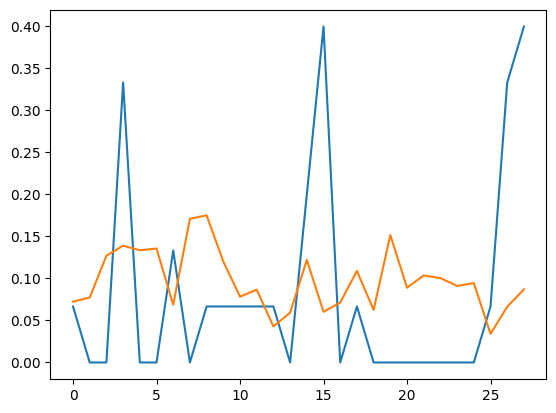

In [132]:
sns.lineplot(test_y[0])
sns.lineplot(predictions)